# Loading Data and Models

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('./drive/My Drive/Tropical_Cyclones_Thesis/ERA5_Dataset')

Mounted at /content/drive


In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingClassifier
from datetime import datetime
import pickle
import metrics
import random

from lime import lime_tabular
import random

In [4]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.15.0


In [5]:
target_names = ['Negative', 'Positive']
print(target_names)

['Negative', 'Positive']


In [6]:
# Import models
base_path = './07_Ensemble_Models/models/XGBoost_D0_MJO_ERA5_13'

mjo_encoder  = tfk.models.load_model('./07_Ensemble_Models/models/MJO_NINO_ENCODER.h5')
era5_encoder = tfk.models.load_model('./07_Ensemble_Models/models/ERA5_ENCODER.h5')
gb_classifier = pickle.load(open("{}/XGBoost_ENS_t+1.dat".format(base_path), "rb")) # Import the GB model

# print(mjo_encoder.summary())
# print(era5_encoder.summary())

In [7]:
import datetime

# Function to get the day number of the year
def day_of_year(date):
    return date.timetuple().tm_yday

# List to store day numbers for each day from 1980 to 2021
days_of_year = []

# Iterate over the years from 1980 to 2021
for year in range(2012, 2022):
    start_date = datetime.date(year, 1, 1)
    end_date = datetime.date(year, 12, 31)
    # Iterate over each day of the year
    while start_date <= end_date:
        days_of_year.append(day_of_year(start_date))
        start_date += datetime.timedelta(days=1)

print(len(days_of_year))

days_of_year = np.array(days_of_year)
print(days_of_year.reshape(-1,1).shape)

3653
(3653, 1)


In [8]:
X_test_mjo_timeseries   = np.load('./07_Ensemble_Models/LIME/LIME_test_sets_D1/X_test_mjo_timeseries.npy')
X_test_era5_timeseries  = np.load('./07_Ensemble_Models/LIME/LIME_test_sets_D1/X_test_era5_timeseries.npy')
X_test_era5_d0          = np.load('./07_Ensemble_Models/LIME/LIME_test_sets_D1/X_test_era5_d0.npy')
y_test                  = np.load('./07_Ensemble_Models/LIME/LIME_test_sets_D1/y_test.npy')

print(X_test_mjo_timeseries.shape, X_test_era5_timeseries.shape, X_test_era5_d0.shape, y_test.shape, days_of_year.reshape(-1,1).shape)

X_test = np.hstack((X_test_mjo_timeseries, X_test_era5_timeseries, X_test_era5_d0, days_of_year.reshape(-1,1)))
print(X_test.shape)

(3653, 270) (3653, 6688) (3653, 608) (3653,) (3653, 1)
(3653, 7567)


In [9]:
import datetime

# Function to get the day number of the year
def day_of_year(date):
    return date.timetuple().tm_yday

# List to store day numbers for each day from 1980 to 2021
days_of_year = []

for year in range(1980, 1981):
    start_date = datetime.date(year, 2, 1)
    end_date = datetime.date(year, 12, 31)
    # Iterate over each day of the year
    while start_date <= end_date:
        days_of_year.append(day_of_year(start_date))
        start_date += datetime.timedelta(days=1)

# Iterate over the years from 1980 to 2021
for year in range(1981, 2012):
    start_date = datetime.date(year, 1, 1)
    end_date = datetime.date(year, 12, 31)
    # Iterate over each day of the year
    while start_date <= end_date:
        days_of_year.append(day_of_year(start_date))
        start_date += datetime.timedelta(days=1)

print(len(days_of_year))

days_of_year = np.array(days_of_year)
print(days_of_year.reshape(-1,1).shape)

11657
(11657, 1)


In [10]:
X_train_mjo_timeseries   = np.load('./07_Ensemble_Models/LIME/LIME_train_sets_D1/X_train_mjo_timeseries.npy')
X_train_era5_timeseries  = np.load('./07_Ensemble_Models/LIME/LIME_train_sets_D1/X_train_era5_timeseries.npy')
X_train_era5_d0          = np.load('./07_Ensemble_Models/LIME/LIME_train_sets_D1/X_train_era5_d0.npy')

print(X_train_mjo_timeseries.shape, X_train_era5_timeseries.shape, X_train_era5_d0.shape, days_of_year.reshape(-1,1).shape)

X_train = np.hstack((X_train_mjo_timeseries, X_train_era5_timeseries, X_train_era5_d0, days_of_year.reshape(-1,1)))
print(X_train.shape)

(11657, 270) (11657, 6688) (11657, 608) (11657, 1)
(11657, 7567)


In [11]:
# This class is used to create a model that is composed of 2 encoders
# (that generate a compressed version of the MJO-ENSO and ERA5 timeseries)
# and a XGBoost gradient boosting model that is used as the final classificator
class EnsembleModel:
  def __init__(self, era5_encoder, mjo_encoder, xgb_classifier):
    self.era5_encoder = era5_encoder
    self.mjo_encoder = mjo_encoder
    self.xgb_classifier = xgb_classifier

    self.era5_timeseries_len = era5_encoder.input_shape[1]
    self.era5_timeseries_vars = era5_encoder.input_shape[2]
    self.mjo_timeseries_len = mjo_encoder.input_shape[1]
    self.mjo_timeseries_vars = mjo_encoder.input_shape[2]

  def __str__(self):
    str_mjo = 'ENCODER MJO: \n {} --> {}'.format(self.mjo_encoder.input_shape, self.mjo_encoder.output_shape)
    str_era5 = 'ENCODER ERA5: \n {} --> {}'.format(self.era5_encoder.input_shape, self.era5_encoder.output_shape)
    str_xgboost = 'CLASSIFIER XGBoost: \n {} --> {}'.format('(None, 1140)', '(1)')
    return(str_mjo + '\n' + str_era5 + '\n|\nv\n' + str_xgboost)

  # Predictions are probabilities
  def predict_proba(self, data):
    data_mjo_timeseries   = data[:, 0:270]
    data_era5_timeseries  = data[:, 270:6688+270]
    data_era5_d0          = data[:, 6688+270:]

    mjo_timeseries = self.build_timeseries(data_mjo_timeseries, self.mjo_encoder.input_shape[1], self.mjo_encoder.input_shape[2])
    era5_timeseries = self.build_timeseries(data_era5_timeseries, self.era5_encoder.input_shape[1], self.era5_encoder.input_shape[2])
    encoded_mjo = self.mjo_encoder.predict(mjo_timeseries)
    encoded_era5 = self.era5_encoder.predict(era5_timeseries)

    data = np.hstack((data_era5_d0, encoded_mjo, encoded_era5))
    return self.xgb_classifier.predict_proba(data)

  # Predictions are one ore zero if the input is classified as a positive class element
  def predict(self, data):
    data_mjo_timeseries   = data[:, 0:270]
    data_era5_timeseries  = data[:, 270:6688+270]
    data_era5_d0          = data[:, 6688+270:]

    mjo_timeseries = self.build_timeseries(data_mjo_timeseries, self.mjo_encoder.input_shape[1], self.mjo_encoder.input_shape[2])
    era5_timeseries = self.build_timeseries(data_era5_timeseries, self.era5_encoder.input_shape[1], self.era5_encoder.input_shape[2])
    encoded_mjo = self.mjo_encoder.predict(mjo_timeseries)
    encoded_era5 = self.era5_encoder.predict(era5_timeseries)

    data = np.hstack((data_era5_d0, encoded_mjo, encoded_era5))
    return self.xgb_classifier.predict(data)

  # Supporting function to build a timeseries from tabular data
  def build_timeseries(self, X, len_timeseries, N_vars):
    X_timeseries = np.zeros((len(X), len_timeseries, N_vars))
    i = 0
    for elem in X:
      j = 0
      for var_idx in range(N_vars):
          idx = var_idx*len_timeseries
          X_timeseries[i, :, j] = elem[idx : idx + len_timeseries]
          j += 1
      i += 1
    return X_timeseries

ensemble_model = EnsembleModel(era5_encoder, mjo_encoder, gb_classifier)
print(ensemble_model)

pred_probs = ensemble_model.predict_proba(X_test)
pred = ensemble_model.predict(X_test)
print('Predictions-y_test shape: ', pred.shape, y_test.shape)

ENCODER MJO: 
 (None, 30, 9) --> (None, 20)
ENCODER ERA5: 
 (None, 11, 608) --> (None, 512)
|
v
CLASSIFIER XGBoost: 
 (None, 1140) --> (1)
115/115 [==============================] - 0s 3ms/step
Predictions-y_test shape:  (3653,) (3653,)


In [12]:
import sklearn
accuracy  = sklearn.metrics.accuracy_score(y_test, pred)
recall    = sklearn.metrics.recall_score(y_test, pred)
f1        = sklearn.metrics.f1_score(y_test, pred)

print('ACCURACY : ', accuracy)
print('RECALL   : ', recall)
print('F1       : ', f1)

ACCURACY :  0.9176019709827539
RECALL   :  0.8287401574803149
F1       :  0.73665791776028


In [13]:
y_test[0:70]

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1])

In [14]:
tp_idx = []
tn_idx = []

for idx in range(len(pred)):
  if pred[idx] == y_test[idx] == 1:
    tp_idx.append(idx)
  elif pred[idx] == y_test[idx] == 0:
    tn_idx.append(idx)

print(tp_idx)
print(tn_idx)

[0, 1, 2, 3, 4, 5, 7, 10, 11, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 286, 287, 288, 289, 290, 341, 342, 343, 344, 345, 346, 366, 367, 368, 369, 370, 377, 393, 394, 395, 396, 397, 398, 399, 407, 408, 409, 410, 411, 412, 413, 415, 416, 417, 418, 419, 420, 421, 463, 464, 465, 466, 467, 468, 469, 470, 471, 494, 495, 716, 717, 718, 719, 720, 721, 722, 723, 729, 730, 731, 732, 733, 734, 735, 739, 740, 741, 742, 743, 744, 745, 746, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 779, 780, 781, 782, 819, 824, 825, 1051, 1052, 1053, 1095, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1132, 1134, 1150, 1151, 1152, 1153, 1154, 1160, 1162, 1163, 1165, 1166, 1167, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1419, 1420, 1421, 1422, 1423, 1441, 1442, 1481, 1482, 1483, 1484, 1486, 1502, 1503, 1505, 1506, 1507, 1508, 150

# LIME

### Build LIME explainer

In [47]:
era5_d0_features              = np.load('./07_Ensemble_Models/LIME/LIME_train_sets_D1/era5_d0_names.npy')
mjo_enso_timeseries_features  = np.load('./07_Ensemble_Models/LIME/LIME_train_sets_D1/mjo_enso_timeseries_names.npy')
era5_timeseries_features      = np.load('./07_Ensemble_Models/LIME/LIME_train_sets_D1/era5_timeseries_names.npy')

print(mjo_enso_timeseries_features.shape, era5_timeseries_features.shape, era5_d0_features.shape)
feature_names = list(mjo_enso_timeseries_features) + list(era5_timeseries_features) + list(era5_d0_features) + ['yday']
print(len(feature_names))

(270,) (6688,) (608,)
7567


In [48]:
explainer = lime_tabular.LimeTabularExplainer(X_train,
                                              mode="classification",
                                              class_names = target_names,
                                              feature_names = feature_names,
                                             )

In [108]:
from datetime import datetime, timedelta

def get_idx_from_date(date: datetime):
  first_date = datetime(2012, 1, 1)
  return (date - first_date).days

# Date of the cyclone I want to plot
date = datetime(2018, 1, 3)
idx = get_idx_from_date(date)
print('DATE: ', date)
print('IDX: ', idx)
print(idx in tp_idx)

print(tp_idx[tp_idx.index(idx)-4: tp_idx.index(idx)+4])

DATE:  2018-01-03 00:00:00
IDX:  2194
True
[1895, 1896, 1899, 2193, 2194, 2195, 2196, 2197]


In [109]:
from datetime import datetime, timedelta

# Initialize a list to store explanations for the entire test set
explanations = []

#idx = tp_idx[random.randint(0, len(tp_idx))]
idx = get_idx_from_date(date)
print(idx)
if idx in tp_idx:
  pred = target_names[int(ensemble_model.predict(X_test[idx].reshape(1,-1))[0])]
  actual = target_names[int(y_test[idx])]
  print('PREDICTED: ', pred)
  print('ACTUAL:    ', actual)

  first_date = datetime(2012, 1, 1)
  idx_date = first_date + timedelta(days=idx)
  print("Sample IDX: ", idx)
  print("Sample Date:", idx_date.strftime("%Y-%m-%d"))

  explanation = explainer.explain_instance(X_test[idx].reshape(-1), ensemble_model.predict_proba, num_features=7567)
  rule_list = explanation.as_list()

2194
1/1 [==============================] - 0s 19ms/step
PREDICTED:  Positive
ACTUAL:     Positive
Sample IDX:  2194
Sample Date: 2018-01-03
157/157 [==============================] - 0s 3ms/step


In [110]:
#explanation.show_in_notebook(show_table=True, show_all=False)

### Evaluate the relevance of timeseries and meteorological data

In [111]:
def is_substring_in_list(main_string, substring_list):
    for substring in substring_list:
        if substring in main_string:
            return True
    return False

mjo_timeseries_score = 0
era5_timeseries_score = 0
era5_variables_score = 0

for elem in rule_list:
  #print(elem[0])
  if is_substring_in_list(elem[0], mjo_enso_timeseries_features):
    mjo_timeseries_score += elem[1]
  elif is_substring_in_list(elem[0], era5_timeseries_features):
    era5_timeseries_score += elem[1]
  elif is_substring_in_list(elem[0], era5_d0_features):
    era5_variables_score += elem[1]

print('MJO TIMESERIES SCORE: ', mjo_timeseries_score)
print('ERA5 TIMESERIES SCORE: ', era5_timeseries_score)
print('ERA5 VARIABLES SCORE: ', era5_variables_score)
print('SCORE SUM: ', mjo_timeseries_score+era5_timeseries_score+era5_variables_score)

MJO TIMESERIES SCORE:  0.04159523567292668
ERA5 TIMESERIES SCORE:  0.25986050751885803
ERA5 VARIABLES SCORE:  0.23145099020462148
SCORE SUM:  0.5329067333964062


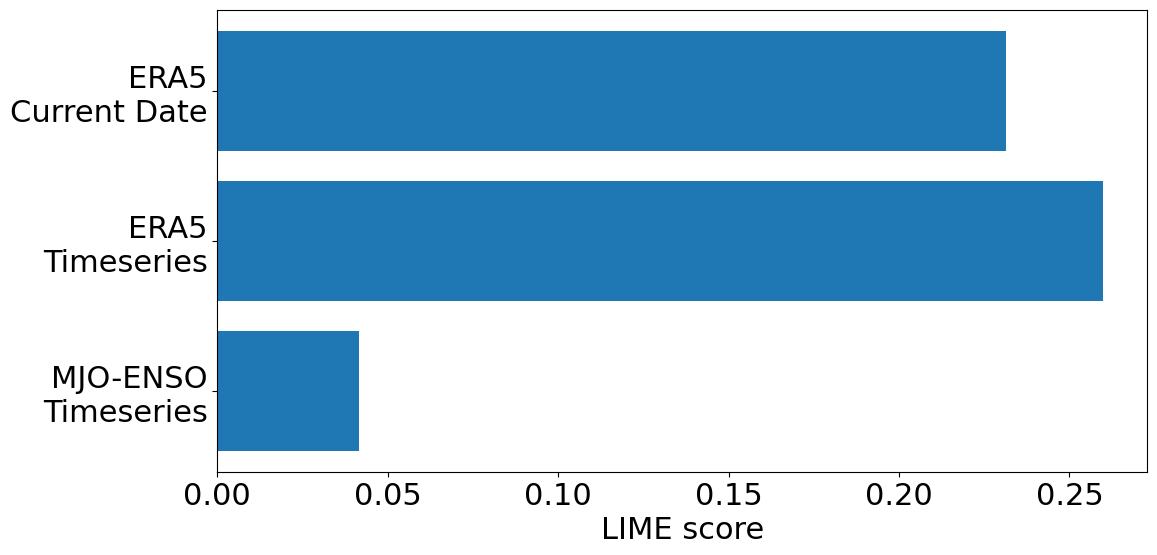

In [112]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

# Create a bar chart with inverted axes
fig, ax1 = plt.subplots(figsize=(12, 6))
vars_scores = [mjo_timeseries_score, era5_timeseries_score, era5_variables_score]

indices = range(len(vars_scores))

ax1.barh(['MJO-ENSO\nTimeseries','ERA5\nTimeseries','ERA5\nCurrent Date'], vars_scores, label='Occurrences')
ax1.set_xlabel('LIME score')
ax1.set_ylabel('')

#plt.title('Relevance of datasets for {}-{}-{} sample prediction'.format(idx_date.day,idx_date.month,idx_date.year))

plt.show()

### Evaluate the number of relevant rules for each zone

In [113]:
def is_exact_substring(main_string, substring):
    # Check if substring is in the main_string
    if substring in main_string:
        # Check if the substring is not followed by a digit
        index = main_string.find(substring)
        if index + len(substring) == len(main_string) or not main_string[index + len(substring)].isdigit():
            return True
    return False

zone_weights = {
    'Z1': 0,
    'Z2': 0,
    'Z3': 0,
    'Z4': 0,
    'Z5': 0,
    'Z6': 0,
    'Z7': 0,
    'Z8': 0,
    'Z9': 0,
    'Z10': 0,
    'Z11': 0,
    'Z12': 0,
    'Z13': 0,
    'Z14': 0,
    'Z15': 0,
    'Z16': 0
    }

for zone in zone_weights:
  for rule in rule_list:
    if is_exact_substring(rule[0], zone):
      zone_weights[zone] += rule[1]

print(zone_weights)

{'Z1': -0.05865037948208797, 'Z2': 0.03295249665874393, 'Z3': 0.10448212219303897, 'Z4': 0.0020720296786232756, 'Z5': 0.0048060853012717114, 'Z6': 0.07649710185135165, 'Z7': 0.061617848081802526, 'Z8': -0.023201469074595877, 'Z9': -0.04107606315658878, 'Z10': 0.13676710300706538, 'Z11': 0.04664968132818537, 'Z12': 0.06785565726006622, 'Z13': -0.03492032801420572, 'Z14': 0.08971238854684076, 'Z15': -0.0016668050119629052, 'Z16': 0.02741402855593145}


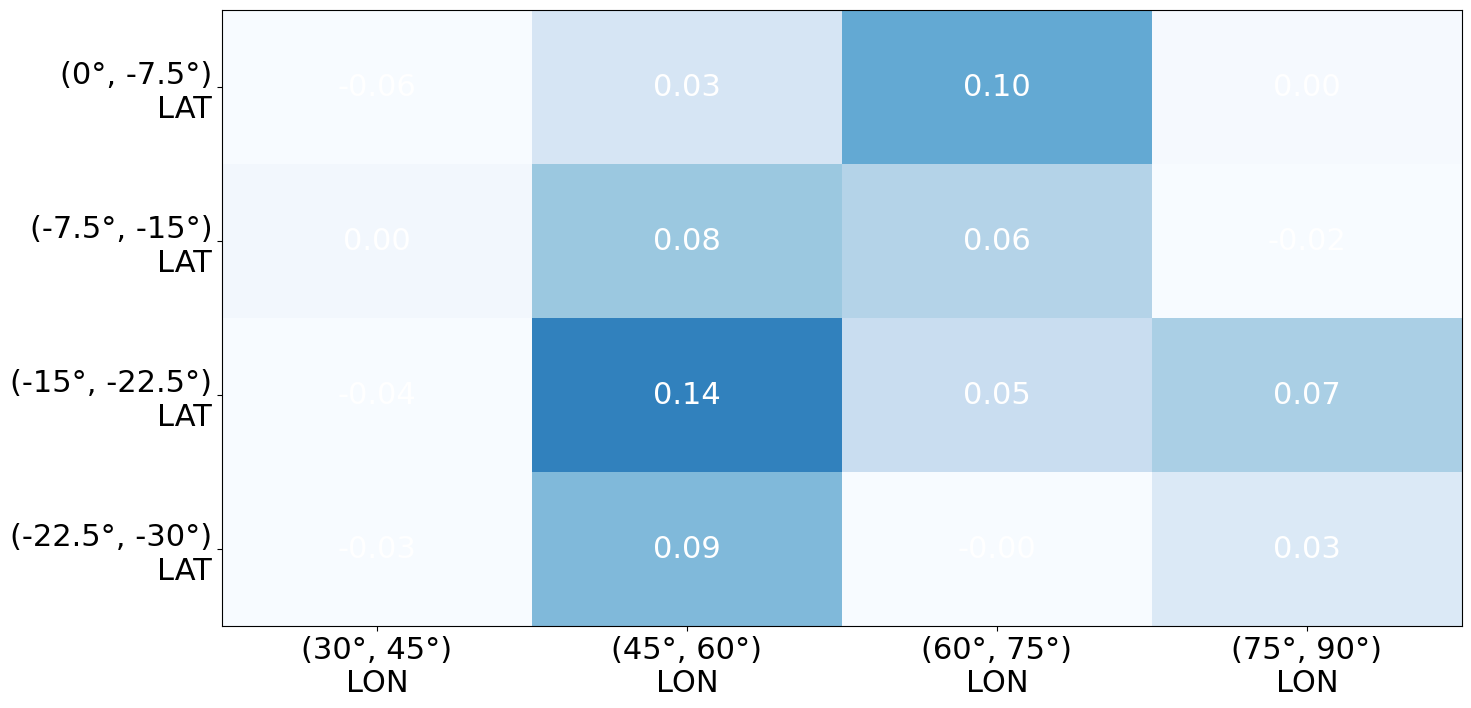

In [114]:
# Extract zones and weights from the dictionary
zones = list(zone_weights.keys())
weights = list(zone_weights.values())

# Create a 2D array for weights (4x4)
heatmap_data = np.array(weights).reshape(4, 4)

# Plot the heatmap
plt.figure(figsize=(16, 8))
plt.imshow(heatmap_data, cmap='Blues', vmin=0, vmax=0.2, aspect='auto')

# Set the ticks and labels
plt.xticks(np.arange(4), ['(30°, 45°)\nLON', '(45°, 60°)\nLON', '(60°, 75°)\nLON', '(75°, 90°)\nLON'])
plt.yticks(np.arange(4), ['(0°, -7.5°)\nLAT', '(-7.5°, -15°)\nLAT', '(-15°, -22.5°)\nLAT', '(-22.5°, -30°)\nLAT'])

# Display the values on the heatmap
for i in range(4):
    for j in range(4):
        plt.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color='white')

#plt.colorbar()

# Show the plot
plt.show()

In [115]:
df_ibtracs = pd.read_csv('../IBTrACS_Dataset/dataset/ibtracs_original_SI.csv')

<ipython-input-115-c91d794ea2e0>:1: DtypeWarning: Columns (1,2,8,9,14,19,20,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ibtracs = pd.read_csv('../IBTrACS_Dataset/dataset/ibtracs_original_SI.csv')


In [116]:
tc_name = df_ibtracs[df_ibtracs['ISO_TIME'] == idx_date.strftime("%Y-%m-%d 00:00:00")]['NAME'].values
lat_today = df_ibtracs[df_ibtracs['ISO_TIME'] == idx_date.strftime("%Y-%m-%d 00:00:00")]['LAT'].values
lon_today = df_ibtracs[df_ibtracs['ISO_TIME'] == idx_date.strftime("%Y-%m-%d 00:00:00")]['LON'].values

condition_before_tc_day = df_ibtracs['ISO_TIME'] < idx_date.strftime("%Y-%m-%d 00:00:00")
condition_same_name = df_ibtracs['NAME'] == tc_name[0]

track_lat = df_ibtracs.loc[condition_before_tc_day & condition_same_name]['LAT'].values
track_lon = df_ibtracs.loc[condition_before_tc_day & condition_same_name]['LON'].values

df_tc_track = pd.DataFrame({'LAT':track_lat, 'LON':track_lon})
df_today_tc = pd.DataFrame({'LAT': lat_today, 'LON': lon_today})

print('TC NAME: ', tc_name)
print('TC day: ', idx_date.strftime("%Y-%m-%d 00:00:00"))
print('LAT: ', lat_today[0])
print('LON: ', lon_today[0])

TC NAME:  ['AVA']
TC day:  2018-01-03 00:00:00
LAT:  -15.25
LON:  52.7


In [117]:
df_today_tc

,LAT,LON
0,-15.25,52.7


<ipython-input-118-d61a7ce5ddb5>:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


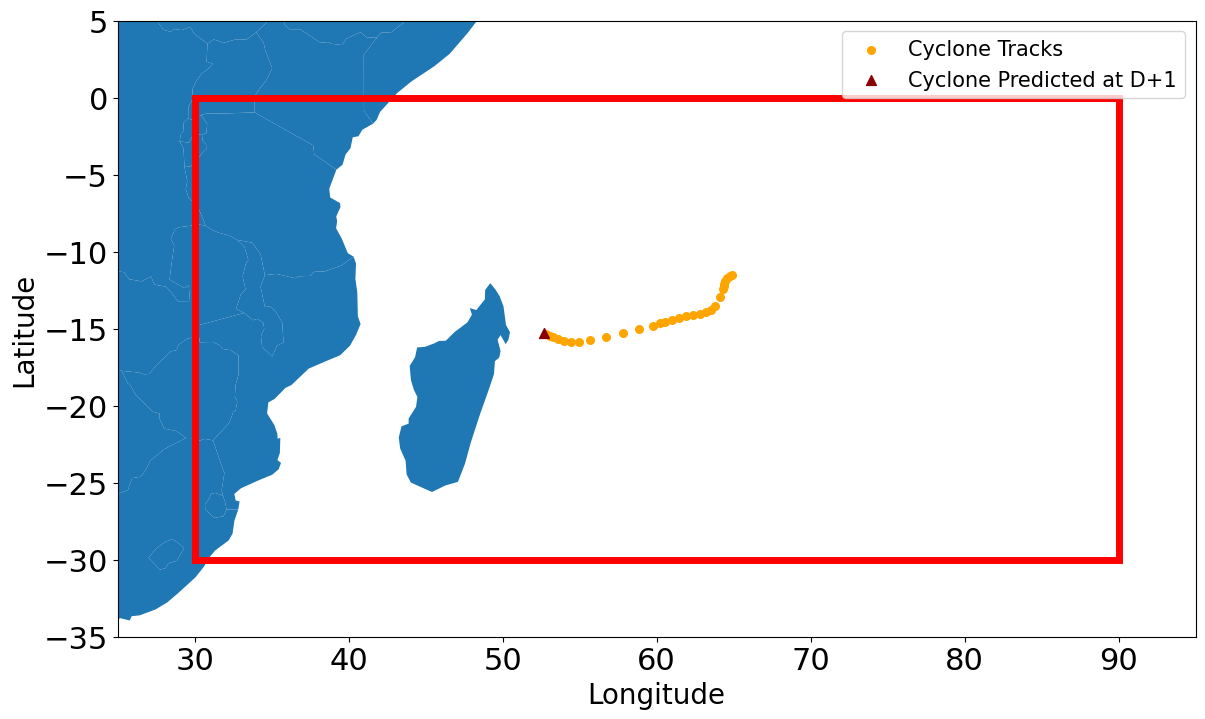

In [118]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.patches as patches

geometry_track = [Point(xy) for xy in zip(df_tc_track['LON'], df_tc_track['LAT'])]
geometry_today_tc = [Point(xy) for xy in zip(df_today_tc['LON'], df_today_tc['LAT'])]

gdf_track = GeoDataFrame(df_tc_track, geometry=geometry_track)
gdf_today = GeoDataFrame(df_today_tc, geometry=geometry_today_tc)

# Define the latitude and longitude boundaries for the specific area
min_lon, max_lon = 25, 95
min_lat, max_lat = -35, 5

# Create a GeoDataFrame for the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Plot the world map and the filtered GeoDataFrame
ax = world.plot(figsize=(16, 8))
gdf_track.plot(ax=ax, marker='o', color='orange', markersize=30, label='Cyclone Tracks')
gdf_today.plot(ax=ax, marker='^', color='darkred', markersize=50, label='Cyclone Predicted at D+1')


ax.set_xlabel('Longitude', size='20')
ax.set_ylabel('Latitude', size='20')
ax.legend(fontsize='15')

# Set the x and y axis limits to focus on the specific area
ax.set_xlim([min_lon, max_lon])
ax.set_ylim([min_lat, max_lat])

# Define the coordinates for the rectangle
rect_min_lon, rect_max_lon = 30, 90
rect_min_lat, rect_max_lat = -30, 0
# Create a rectangle patch
rectangle = patches.Rectangle((rect_min_lon, rect_min_lat), rect_max_lon - rect_min_lon, rect_max_lat - rect_min_lat, linewidth=5, edgecolor='red', facecolor='none')
# Add the rectangle to the plot
ax.add_patch(rectangle)
#plt.grid()

### Evaluate relevance of meteorological variables

In [119]:
meteo_vars_dict = {
    'P_': 0,
    'Vor_': 0,
    'Wind_': 0,
    'T_': 0,
    'Prec_': 0,
    'Air_Density_': 0
}

for rule in rule_list:
  for var in meteo_vars_dict:
    if var in rule[0]:
      meteo_vars_dict[var] += rule[1]

print(meteo_vars_dict)

{'P_': 0.0756449016690419, 'Vor_': 0.14461852522246318, 'Wind_': 0.28652388525572037, 'T_': -0.028498224429690956, 'Prec_': 0.0026342294156498276, 'Air_Density_': 0.010388180590295781}


In [120]:
# meteo_vars_dict['Prec_'] = 0.002

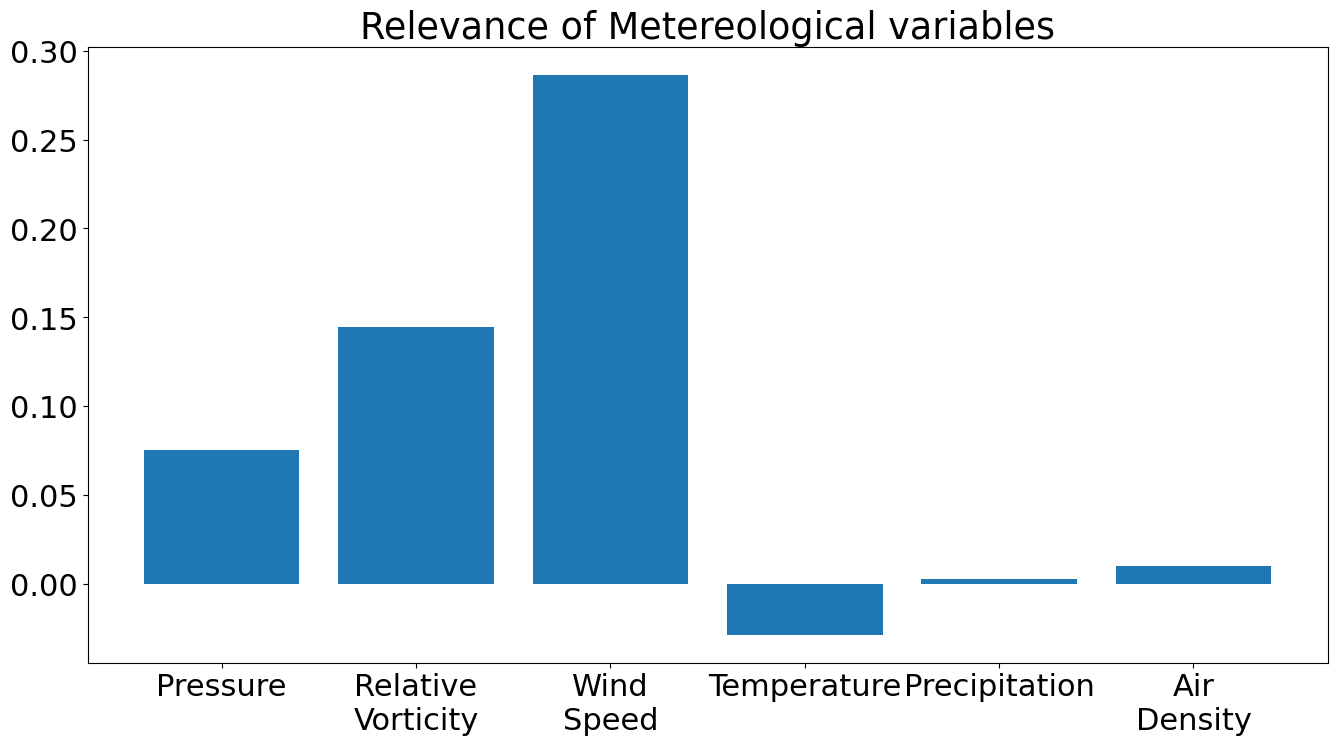

In [121]:
names = ['Pressure', 'Relative\nVorticity', 'Wind\nSpeed', 'Temperature', 'Precipitation', 'Air\nDensity']
values = list(meteo_vars_dict.values())

# Increase the size of the figure by adjusting the figsize parameter
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the bar chart
ax.bar(range(len(meteo_vars_dict)), values, tick_label=names)

plt.title('Relevance of Metereological variables')
plt.show()

In [122]:
era5_timeseries_features[::16*11*2]

array(['P_Mean_Z1-0', 'Vor_850hPa_Mean_Z1-0', 'Vor_550hPa_Mean_Z1-0',
       'Vor_250hPa_Mean_Z1-0', 'Wind_Gust_Mean_Z1-0',
       'Wind_U_10m_Mean_Z1-0', 'Wind_U_1000hPa_Mean_Z1-0',
       'Wind_U_850hPa_Mean_Z1-0', 'Wind_U_300hPa_Mean_Z1-0',
       'Wind_V_10m_Mean_Z1-0', 'Wind_V_1000hPa_Mean_Z1-0',
       'Wind_V_850hPa_Mean_Z1-0', 'Wind_V_300hPa_Mean_Z1-0',
       'T_1000hPa_Mean_Z1-0', 'T_550hPa_Mean_Z1-0', 'T_300hPa_Mean_Z1-0',
       'T_200hPa_Mean_Z1-0', 'Prec_Mean_Z1-0', 'Air_Density_Mean_Z1-0'],
      dtype='<U26')

In [123]:
# Evaluate variables relevance at all the atm levels
meteo_vars_dict = {
    'P_': 0,
    'Vor_850hPa_': 0,
    'Vor_550hPa_': 0,
    'Vor_250hPa_': 0,
    'Wind_Gust_': 0,
    'Wind_U_10m_': 0,
    'Wind_U_1000hPa_': 0,
    'Wind_U_850hPa_': 0,
    'Wind_U_300hPa_': 0,
    'Wind_V_10m_': 0,
    'Wind_V_1000hPa_': 0,
    'Wind_V_850hPa_': 0,
    'Wind_V_300hPa_': 0,
    'T_1000hPa_': 0,
    'T_550hPa_': 0,
    'T_300hPa_': 0,
    'T_200hPa_': 0,
    'Prec_': 0,
    'Air_Density_': 0
}

for rule in rule_list:
  for var in meteo_vars_dict:
    if var in rule[0]:
      meteo_vars_dict[var] += rule[1]

print(meteo_vars_dict)

{'P_': 0.0756449016690419, 'Vor_850hPa_': 0.0764137093349565, 'Vor_550hPa_': 0.01218901286595406, 'Vor_250hPa_': 0.05601580302155265, 'Wind_Gust_': -0.0024239808688992616, 'Wind_U_10m_': 0.022635114945753862, 'Wind_U_1000hPa_': 0.03249644071681648, 'Wind_U_850hPa_': 0.08904856942608638, 'Wind_U_300hPa_': -0.03375230173355056, 'Wind_V_10m_': -0.009816752278497085, 'Wind_V_1000hPa_': 0.028969851673581536, 'Wind_V_850hPa_': 0.1273519658136081, 'Wind_V_300hPa_': 0.03201497756082151, 'T_1000hPa_': 0.009086244149143621, 'T_550hPa_': -0.030861164896249786, 'T_300hPa_': 0.03443944286596776, 'T_200hPa_': -0.0411627465485525, 'Prec_': 0.0026342294156498276, 'Air_Density_': 0.010388180590295781}


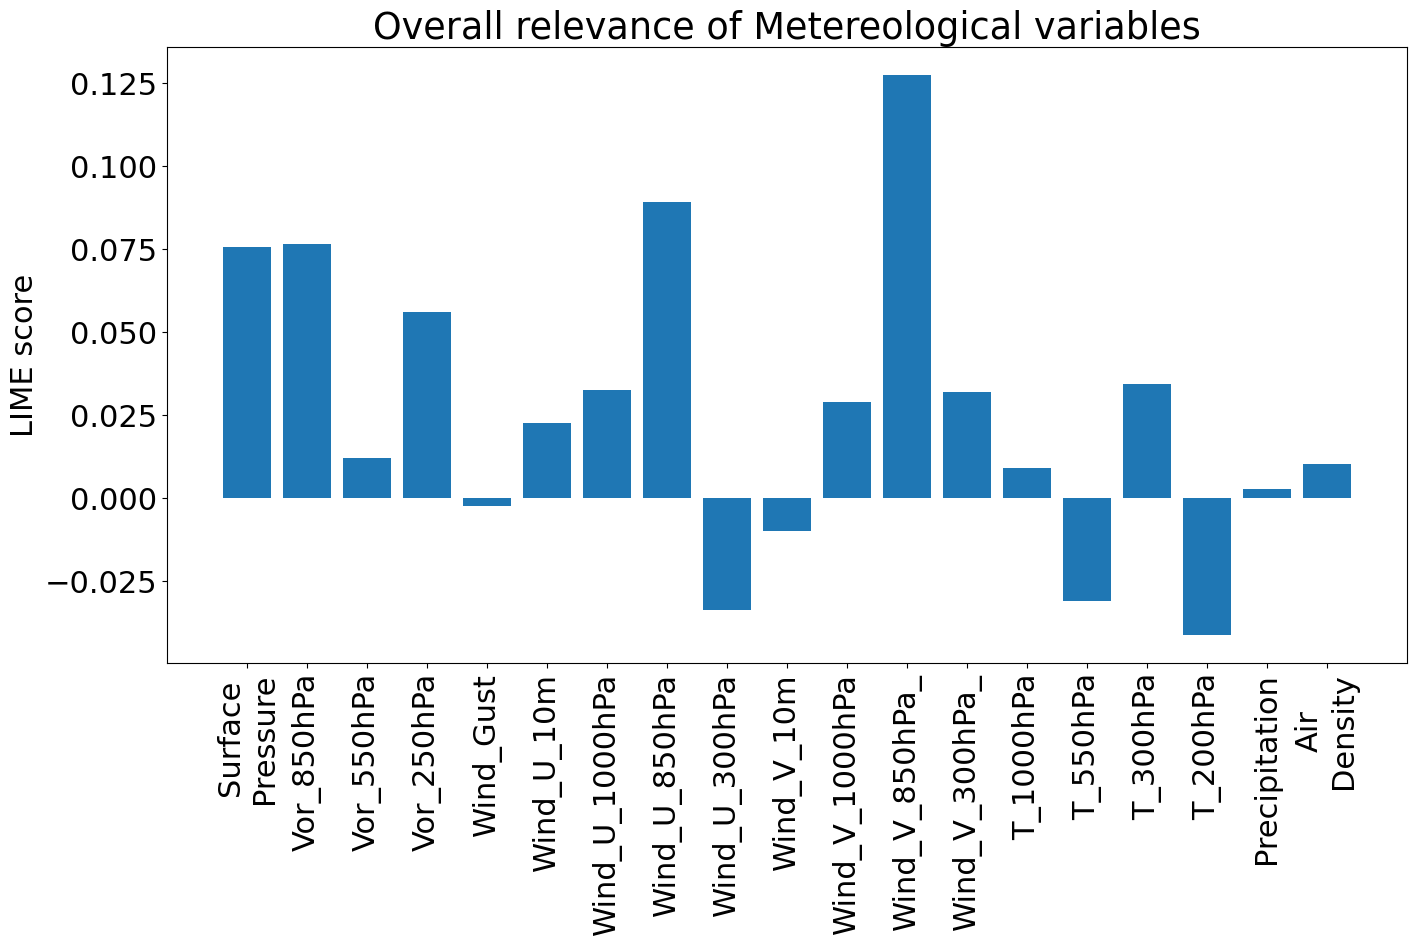

In [124]:
names = ['Surface\nPressure', 'Vor_850hPa', 'Vor_550hPa', 'Vor_250hPa', 'Wind_Gust',
         'Wind_U_10m', 'Wind_U_1000hPa', 'Wind_U_850hPa', 'Wind_U_300hPa',
         'Wind_V_10m', 'Wind_V_1000hPa', 'Wind_V_850hPa_', 'Wind_V_300hPa_',
         'T_1000hPa', 'T_550hPa', 'T_300hPa', 'T_200hPa', 'Precipitation', 'Air\nDensity']
values = list(meteo_vars_dict.values())

# Increase the size of the figure by adjusting the figsize parameter
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the bar chart
ax.bar(range(len(meteo_vars_dict)), values)

ax.set_xticks(range(len(meteo_vars_dict)))
ax.set_xticklabels(names, rotation=90)

plt.ylabel('LIME score')
plt.title('Overall relevance of Metereological variables')
plt.show()

In [125]:
meteo_vars_dict.keys()

dict_keys(['P_', 'Vor_850hPa_', 'Vor_550hPa_', 'Vor_250hPa_', 'Wind_Gust_', 'Wind_U_10m_', 'Wind_U_1000hPa_', 'Wind_U_850hPa_', 'Wind_U_300hPa_', 'Wind_V_10m_', 'Wind_V_1000hPa_', 'Wind_V_850hPa_', 'Wind_V_300hPa_', 'T_1000hPa_', 'T_550hPa_', 'T_300hPa_', 'T_200hPa_', 'Prec_', 'Air_Density_'])

In [126]:
wind_1000hPa_score = meteo_vars_dict['Wind_U_1000hPa_'] + meteo_vars_dict['Wind_V_1000hPa_']
wind_850hPa_score = meteo_vars_dict['Wind_U_850hPa_'] + meteo_vars_dict['Wind_V_850hPa_']
wind_300hPa_score = meteo_vars_dict['Wind_U_300hPa_'] + meteo_vars_dict['Wind_V_300hPa_']
wind_10m_score = meteo_vars_dict['Wind_U_10m_'] + meteo_vars_dict['Wind_V_10m_']

meteo_vars_dict_new = {
    'P_': 0,
    'Vor_850hPa_': 0,
    'Vor_550hPa_': 0,
    'Vor_250hPa_': 0,
    'Wind_Gust_': 0,
    'Wind_10m': 0,
    'Wind_1000hPa': 0,
    'Wind_850hPa': 0,
    'Wind_300hPa': 0,
    'T_1000hPa_': 0,
    'T_550hPa_': 0,
    'T_300hPa_': 0,
    'T_200hPa_': 0,
    'Prec_': 0,
    'Air_Density_': 0
}

for key in meteo_vars_dict_new:
  if key in meteo_vars_dict.keys():
    meteo_vars_dict_new[key] = meteo_vars_dict[key]
  else:
    if key == 'Wind_10m':
      meteo_vars_dict_new[key] = wind_10m_score
    elif key == 'Wind_1000hPa':
      meteo_vars_dict_new[key] = wind_1000hPa_score
    elif key == 'Wind_850hPa':
      meteo_vars_dict_new[key] = wind_850hPa_score
    elif key == 'Wind_300hPa':
      meteo_vars_dict_new[key] = wind_300hPa_score
    else:
      print('ERROR')

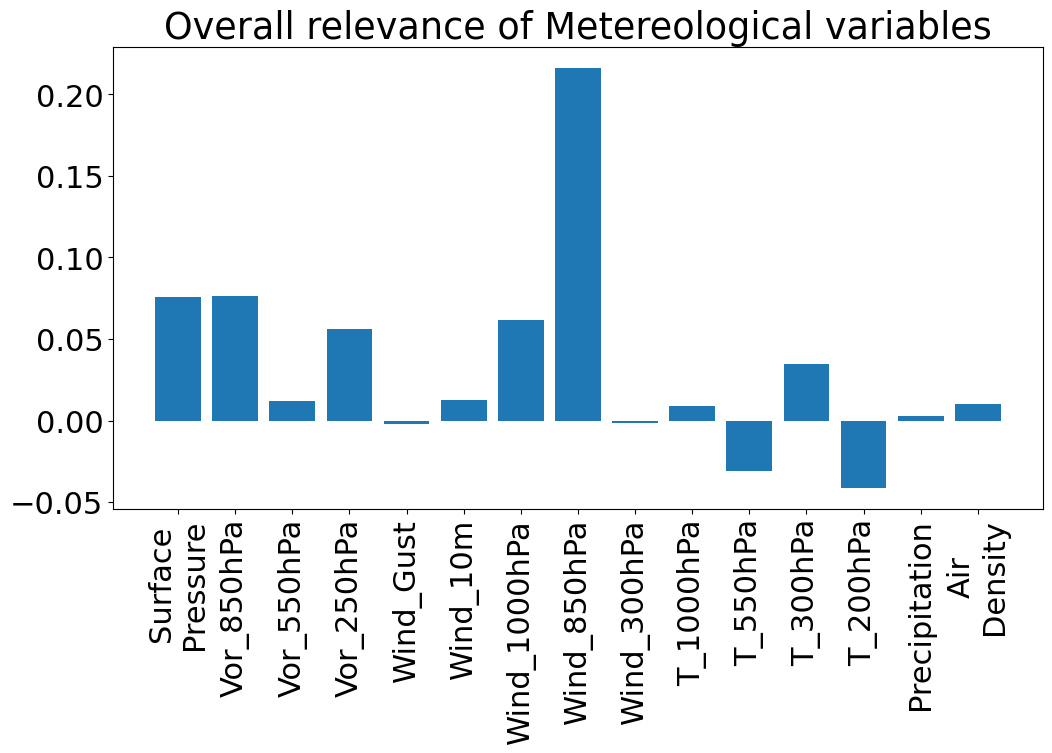

In [127]:
names = ['Surface\nPressure', 'Vor_850hPa', 'Vor_550hPa', 'Vor_250hPa', 'Wind_Gust',
         'Wind_10m', 'Wind_1000hPa', 'Wind_850hPa', 'Wind_300hPa',
         'T_1000hPa', 'T_550hPa', 'T_300hPa', 'T_200hPa', 'Precipitation', 'Air\nDensity']
values = list(meteo_vars_dict_new.values())

# Increase the size of the figure by adjusting the figsize parameter
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bar chart
ax.bar(range(len(meteo_vars_dict_new)), values)

ax.set_xticks(range(len(meteo_vars_dict_new)))
ax.set_xticklabels(names, rotation=90)


plt.title('Overall relevance of Metereological variables')
plt.show()

### Evaluate relevance of points in MJO timeseries

In [128]:
print(X_test_mjo_timeseries[idx].shape)
print(mjo_enso_timeseries_features.shape)

print(mjo_enso_timeseries_features[0::29])

(270,)
(270,)
['RMM1-1' 'RMM1-30' 'RMM2-29' 'Phase-28' 'nino3-27' 'nino4-26' 'nino12-25'
 'nino34-24' 'indocW-23' 'indocE-22']


In [129]:
mjo_vars_dict = {}

for key in mjo_enso_timeseries_features:
  mjo_vars_dict[key] = 0

print(mjo_vars_dict)

for rule in rule_list:
  for var in mjo_vars_dict:
    if var in rule[0]:
      mjo_vars_dict[var] += rule[1]

print(mjo_vars_dict)

{'RMM1-1': 0, 'RMM1-2': 0, 'RMM1-3': 0, 'RMM1-4': 0, 'RMM1-5': 0, 'RMM1-6': 0, 'RMM1-7': 0, 'RMM1-8': 0, 'RMM1-9': 0, 'RMM1-10': 0, 'RMM1-11': 0, 'RMM1-12': 0, 'RMM1-13': 0, 'RMM1-14': 0, 'RMM1-15': 0, 'RMM1-16': 0, 'RMM1-17': 0, 'RMM1-18': 0, 'RMM1-19': 0, 'RMM1-20': 0, 'RMM1-21': 0, 'RMM1-22': 0, 'RMM1-23': 0, 'RMM1-24': 0, 'RMM1-25': 0, 'RMM1-26': 0, 'RMM1-27': 0, 'RMM1-28': 0, 'RMM1-29': 0, 'RMM1-30': 0, 'RMM2-1': 0, 'RMM2-2': 0, 'RMM2-3': 0, 'RMM2-4': 0, 'RMM2-5': 0, 'RMM2-6': 0, 'RMM2-7': 0, 'RMM2-8': 0, 'RMM2-9': 0, 'RMM2-10': 0, 'RMM2-11': 0, 'RMM2-12': 0, 'RMM2-13': 0, 'RMM2-14': 0, 'RMM2-15': 0, 'RMM2-16': 0, 'RMM2-17': 0, 'RMM2-18': 0, 'RMM2-19': 0, 'RMM2-20': 0, 'RMM2-21': 0, 'RMM2-22': 0, 'RMM2-23': 0, 'RMM2-24': 0, 'RMM2-25': 0, 'RMM2-26': 0, 'RMM2-27': 0, 'RMM2-28': 0, 'RMM2-29': 0, 'RMM2-30': 0, 'Phase-1': 0, 'Phase-2': 0, 'Phase-3': 0, 'Phase-4': 0, 'Phase-5': 0, 'Phase-6': 0, 'Phase-7': 0, 'Phase-8': 0, 'Phase-9': 0, 'Phase-10': 0, 'Phase-11': 0, 'Phase-12': 0, 'Phase

In [130]:
steps_dict = {}

for step in range(30):
  steps_dict['-{}'.format(step+1)] = 0

print(steps_dict)

for key in steps_dict:
  for var in mjo_vars_dict:
    if key in var:
      steps_dict[key] += mjo_vars_dict[var]

print(steps_dict)

{'-1': 0, '-2': 0, '-3': 0, '-4': 0, '-5': 0, '-6': 0, '-7': 0, '-8': 0, '-9': 0, '-10': 0, '-11': 0, '-12': 0, '-13': 0, '-14': 0, '-15': 0, '-16': 0, '-17': 0, '-18': 0, '-19': 0, '-20': 0, '-21': 0, '-22': 0, '-23': 0, '-24': 0, '-25': 0, '-26': 0, '-27': 0, '-28': 0, '-29': 0, '-30': 0}
{'-1': 0.057035809552937376, '-2': 0.016374628187811987, '-3': -0.016331809604591588, '-4': -0.01126113229755789, '-5': 0.0149010497797832, '-6': 0.0067045659666254585, '-7': 0.007494374023185022, '-8': 0.010775579554972235, '-9': -0.005814623934685412, '-10': 0.013888307393018514, '-11': -0.003643056556860953, '-12': 0.00653151551912839, '-13': 0.005953604972100484, '-14': 0.009967114871986798, '-15': -0.0007883245747205582, '-16': 0.004509504486438843, '-17': -0.011457055798518249, '-18': 0.008060149411146024, '-19': -0.0028685060386213013, '-20': 0.006190504656014869, '-21': -0.007151258783046383, '-22': 0.0023194028184394225, '-23': 0.004978131935042736, '-24': 0.003096917357528388, '-25': 0.005

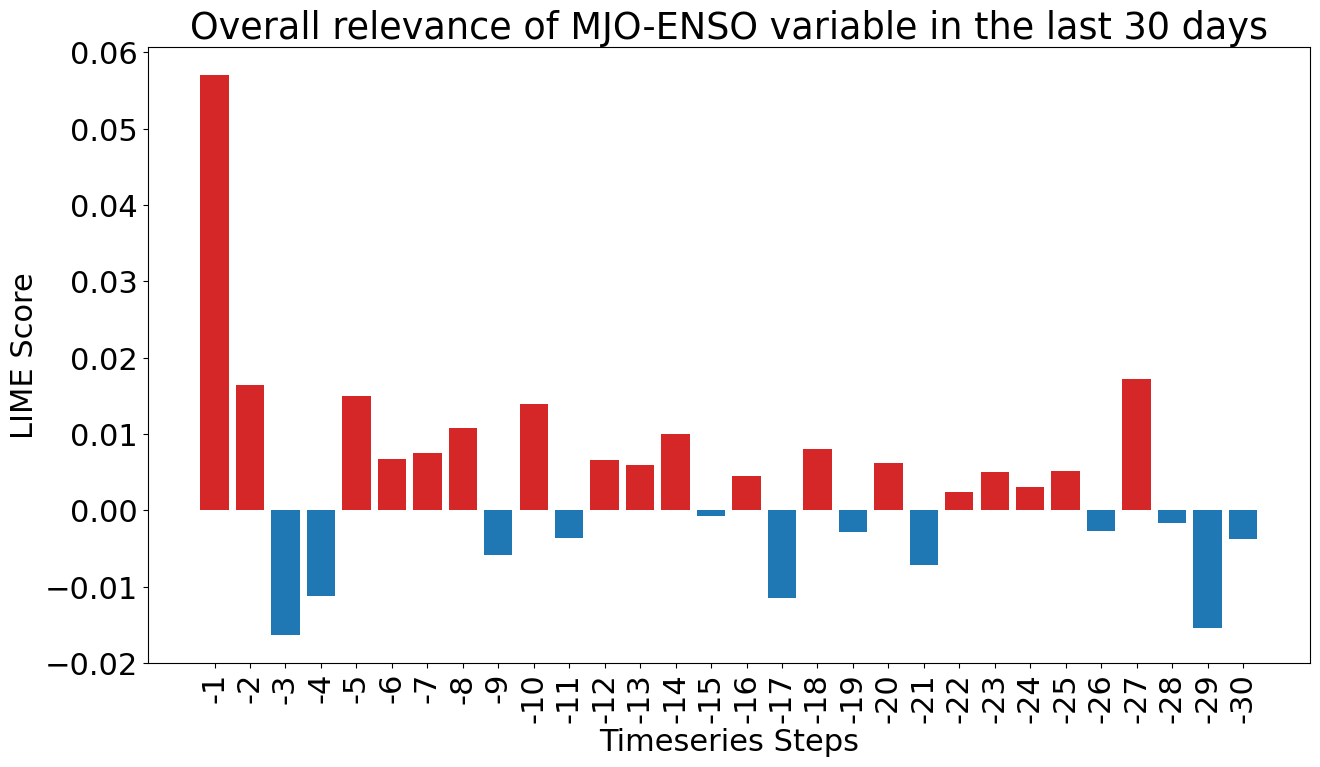

In [131]:
names = list(steps_dict.keys())
values = list(steps_dict.values())

# Increase the size of the figure by adjusting the figsize parameter
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the bar chart with different colors for positive and non-positive values
bars = ax.bar(range(len(steps_dict)), values, color=['C3' if val > 0 else 'C0' for val in values])

ax.set_xticks(range(len(steps_dict)))
ax.set_xticklabels(names, rotation=90)

plt.title('Overall relevance of MJO-ENSO variable in the last 30 days')
plt.xlabel('Timeseries Steps')
plt.ylabel('LIME Score')
plt.show()


In [132]:
mjo_enso_sample = X_test_mjo_timeseries[idx]
x = np.arange(-1, -31, -1)
y_rmm1 = mjo_enso_sample[0:30]
y_rmm2 = mjo_enso_sample[30:60]
y_phase = mjo_enso_sample[60:90]

y_nino3 = mjo_enso_sample[90:120]
y_nino4 = mjo_enso_sample[120:150]
y_nino12 = mjo_enso_sample[150:180]
y_nino34 = mjo_enso_sample[180:210]
y_indocW = mjo_enso_sample[210:240]
y_indocE = mjo_enso_sample[240:]

print(x.shape, y_rmm1.shape)

(30,) (30,)


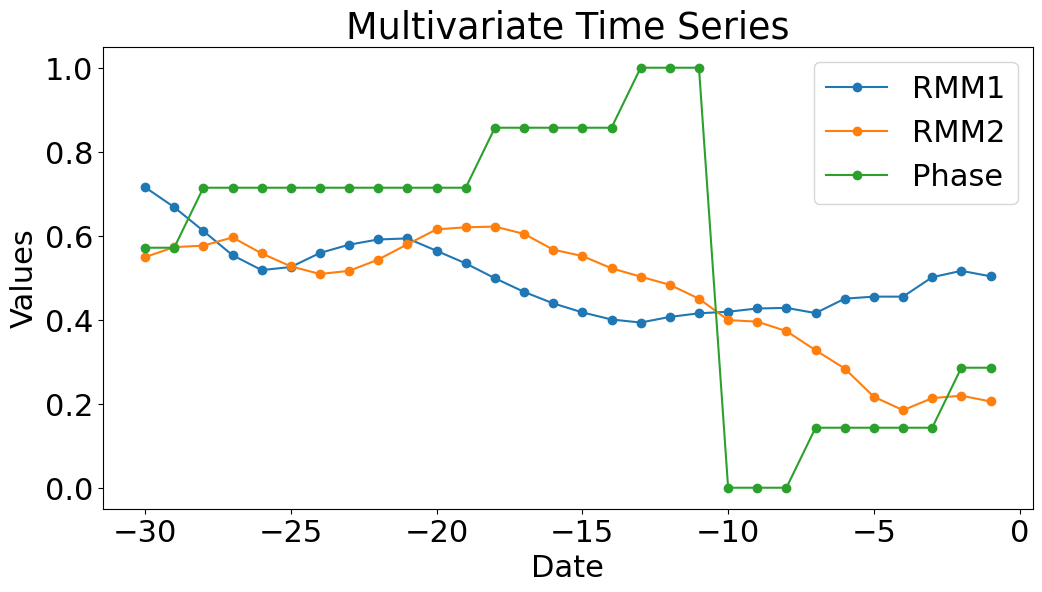

In [133]:
# Plotting multivariate time series
plt.figure(figsize=(12, 6))

plt.plot(x, y_rmm1, label='RMM1', marker='o')
plt.plot(x, y_rmm2, label='RMM2', marker='o')
plt.plot(x, y_phase, label='Phase', marker='o')


plt.title('Multivariate Time Series')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

# plt.grid(True)
plt.show()

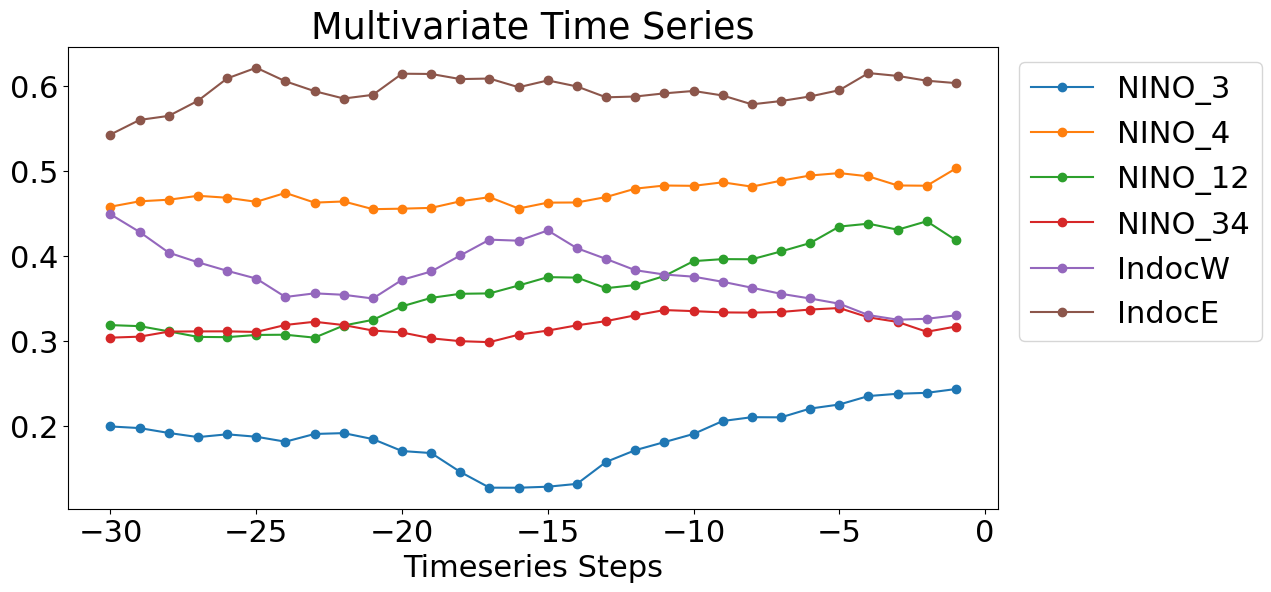

In [134]:
# Plotting multivariate time series
plt.figure(figsize=(12, 6))

plt.plot(x, y_nino3, label='NINO_3', marker='o')
plt.plot(x, y_nino4, label='NINO_4', marker='o')
plt.plot(x, y_nino12, label='NINO_12', marker='o')
plt.plot(x, y_nino34, label='NINO_34', marker='o')
plt.plot(x, y_indocW, label='IndocW', marker='o')
plt.plot(x, y_indocE, label='IndocE', marker='o')

plt.title('Multivariate Time Series')
plt.xlabel('Timeseries Steps')
plt.ylabel('')
#plt.legend()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

# plt.grid(True)
plt.show()

[[ 1.46372928e-02 -2.02416652e-02 -1.06888841e-02 -6.27093876e-03
   6.06922437e-03  5.13782709e-03  3.03606927e-03  2.46814299e-03
   3.08226768e-03  5.78183973e-03 -1.16981038e-03  7.50913190e-03
   4.42741262e-03  4.83046064e-03 -1.85249612e-03  2.40230388e-03
  -1.63401052e-03 -8.12712602e-04 -2.21709172e-03  7.13781521e-04
  -7.65180610e-03  8.94248454e-05  2.58843435e-03  2.62734933e-03
  -5.60120648e-03 -1.73156037e-03  2.85096506e-03 -5.13086126e-04
  -5.96154049e-03 -4.30653131e-03]]
['RMM1-1', 'RMM1-2', 'RMM1-3', 'RMM1-4', 'RMM1-5', 'RMM1-6', 'RMM1-7', 'RMM1-8', 'RMM1-9', 'RMM1-10', 'RMM1-11', 'RMM1-12', 'RMM1-13', 'RMM1-14', 'RMM1-15', 'RMM1-16', 'RMM1-17', 'RMM1-18', 'RMM1-19', 'RMM1-20', 'RMM1-21', 'RMM1-22', 'RMM1-23', 'RMM1-24', 'RMM1-25', 'RMM1-26', 'RMM1-27', 'RMM1-28', 'RMM1-29', 'RMM1-30']


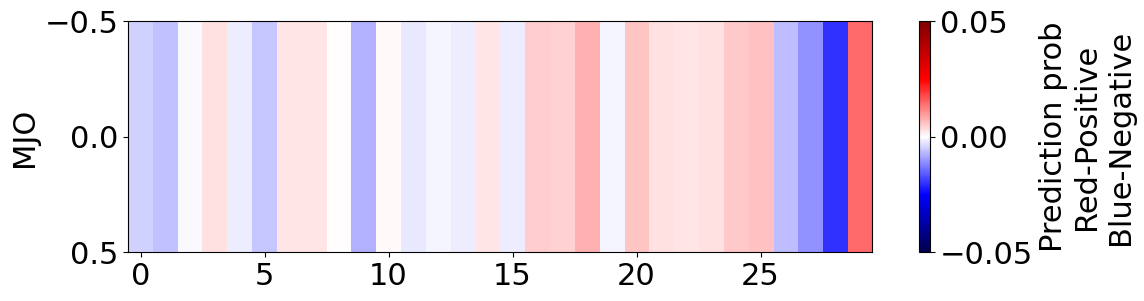

In [135]:
val = list(mjo_vars_dict.values())
keys = list(mjo_vars_dict.keys())

val_rmm1  = np.array(val[0:30])
val_rmm2  = np.array(val[30:60])
val_phase = np.array(val[60:90])

val = np.sum([val_rmm1, val_rmm2, val_phase], axis=0)
val = val.reshape(1,30)
print(val[0:30])
print(keys[0:30])


plt.figure(figsize=(12, 3))
# Plot the horizontal heatmap
plt.imshow(np.flip(val), cmap='seismic', vmin=-0.05, vmax=0.05, aspect='auto', interpolation='nearest')

# Customize the plot
plt.colorbar(label='Prediction prob\nRed-Positive\nBlue-Negative')  # Add a colorbar
plt.ylabel('MJO')
plt.title('')

plt.show()

[[ 0.01224526  0.02466055 -0.00181714 -0.00499019  0.00883183  0.00156674
   0.0044583   0.00830744 -0.00889689  0.00810647 -0.00247325 -0.00097762
   0.00152619  0.00513665  0.00106417  0.0021072  -0.00982305  0.00887286
  -0.00065141  0.00547672  0.00050055  0.00222998  0.0023897   0.00046957
   0.01076411 -0.00096989  0.01432047 -0.00116544 -0.00947078  0.00048074]]
['RMM1-1', 'RMM1-2', 'RMM1-3', 'RMM1-4', 'RMM1-5', 'RMM1-6', 'RMM1-7', 'RMM1-8', 'RMM1-9', 'RMM1-10', 'RMM1-11', 'RMM1-12', 'RMM1-13', 'RMM1-14', 'RMM1-15', 'RMM1-16', 'RMM1-17', 'RMM1-18', 'RMM1-19', 'RMM1-20', 'RMM1-21', 'RMM1-22', 'RMM1-23', 'RMM1-24', 'RMM1-25', 'RMM1-26', 'RMM1-27', 'RMM1-28', 'RMM1-29', 'RMM1-30']


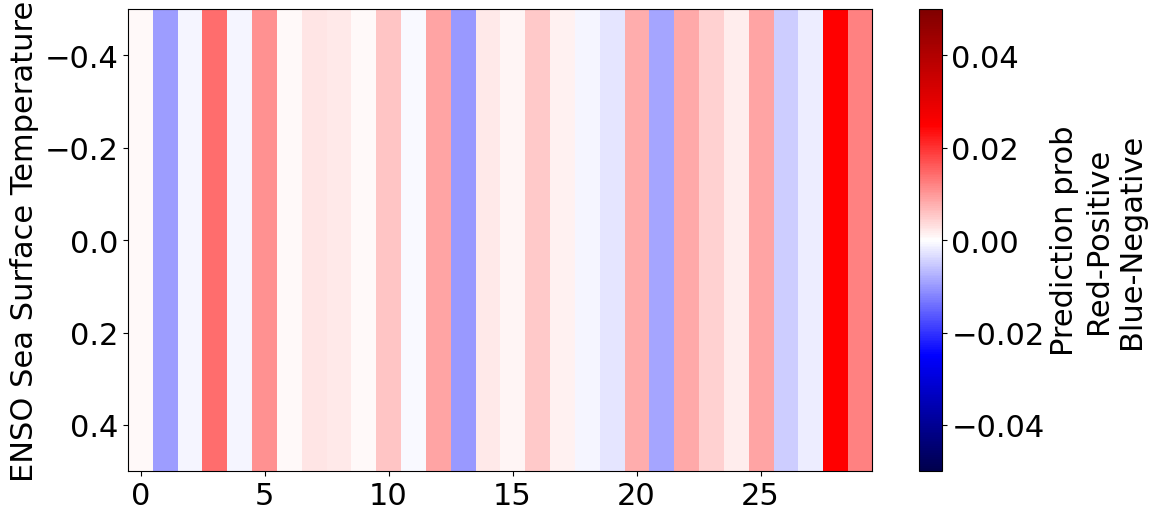

In [136]:
val = list(mjo_vars_dict.values())
keys = list(mjo_vars_dict.keys())

val_nino3  = np.array(val[90:120])
val_nino4  = np.array(val[120:150])
val_nino12 = np.array(val[150:180])
val_nino34  = np.array(val[180:210])
val_indocW  = np.array(val[210:240])
val_indocE = np.array(val[240:])

val = np.sum([val_nino3, val_nino4, val_nino12, val_nino34, val_indocW, val_indocE], axis=0)
val = val.reshape(1,30)
print(val[0:30])
print(keys[0:30])


plt.figure(figsize=(12, 6))
# Plot the horizontal heatmap
plt.imshow(np.flip(val), cmap='seismic', vmin=-0.05, vmax=0.05, aspect='auto', interpolation='nearest')

# Customize the plot
plt.colorbar(label='Prediction prob\nRed-Positive\nBlue-Negative')  # Add a colorbar
plt.ylabel('ENSO Sea Surface Temperature')
# plt.title('ENSO Sea Surface Temperature - Timeseries Analysis')

plt.show()